In [19]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt

#Load and clean the dataset 
def load_airfoil_dataset(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path)

    num_cols = [
        "Re",
        "max_thickness",
        "x_at_max_thickness",
        "max_camber",
        "x_at_max_camber",
        "stall_angle",
        "cl_at_stall",
        "sharpness_rating",
        "radius_rating",
    ]
    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    return df

csv_path = "airfoil_geometry_and_angel_of_stall_data.csv"   # change path if needed
df = load_airfoil_dataset(csv_path)

print("Raw shape:", df.shape)
df.head()


Raw shape: (4967, 11)


,airfoil_id,polar_id,Re,max_thickness,x_at_max_thickness,max_camber,x_at_max_camber,max_cl,alpha_at_max_cl,sharpness_rating,radius_rating
0,ag03-il,xf-ag03-il-100000,100000.0,0.046692,0.065,0.051173,0.281,1.0880,9.25,92.966907,7.033093
1,ag03-il,xf-ag03-il-1000000,1000000.0,0.046692,0.065,0.051173,0.281,1.3785,12.25,92.966907,7.033093
2,ag03-il,xf-ag03-il-200000,200000.0,0.046692,0.065,0.051173,0.281,1.1490,10.25,92.966907,7.033093
3,ag03-il,xf-ag03-il-50000,50000.0,0.046692,0.065,0.051173,0.281,1.0089,8.50,92.966907,7.033093
4,ag03-il,xf-ag03-il-500000,500000.0,0.046692,0.065,0.051173,0.281,1.2897,11.25,92.966907,7.033093


In [20]:
#Build feature matrix X and target y (stall angle)
# Use log10(Re) as a feature – more linear, common in aero

df["log10_Re"] = np.log10(df["Re"].astype(float))

FEATURE_COLS = [
    "max_thickness",
    "x_at_max_thickness",
    "max_camber",
    "x_at_max_camber",
    "sharpness_rating",      # front radius
    "radius_rating",   # rear sharpness
    "log10_Re",
]

TARGET_COL = "max_cl"   # stall angle label

# Drop rows with any missing values in features/target
df_clean = df.dropna(subset=FEATURE_COLS + [TARGET_COL]).copy()

X = df_clean[FEATURE_COLS].values.astype(np.float32)
y = df_clean[TARGET_COL].values.astype(np.float32)

print("X shape:", X.shape)
print("y shape:", y.shape)
df_clean[FEATURE_COLS + [TARGET_COL]].head()


X shape: (4967, 7)
y shape: (4967,)


,max_thickness,x_at_max_thickness,max_camber,x_at_max_camber,sharpness_rating,radius_rating,log10_Re,max_cl
0,0.046692,0.065,0.051173,0.281,92.966907,7.033093,5.00000,1.0880
1,0.046692,0.065,0.051173,0.281,92.966907,7.033093,6.00000,1.3785
2,0.046692,0.065,0.051173,0.281,92.966907,7.033093,5.30103,1.1490
3,0.046692,0.065,0.051173,0.281,92.966907,7.033093,4.69897,1.0089
4,0.046692,0.065,0.051173,0.281,92.966907,7.033093,5.69897,1.2897


In [21]:
#Train the data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)

#Train the Random Forest stall-angle model
#Tuning the parameters below can squeeze out 5-15% better performance 

stall_rf = RandomForestRegressor(
    n_estimators=400,   # number of trees
    max_depth=None,     # let trees grow until leaves are pure
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1,          # use all CPU cores
)

stall_rf.fit(X_train, y_train)

y_pred = stall_rf.predict(X_val)


Train: (3973, 7) (3973,)
Val:   (994, 7) (994,)


In [22]:
#Evaluate the performance 
mae  = mean_absolute_error(y_val, y_pred)
mse  = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_val, y_pred)

print(f"Stall angle MAE  (deg): {mae:.3f}")
print(f"Stall angle RMSE (deg): {rmse:.3f}")
print(f"Stall angle R²:         {r2:.3f}")


Stall angle MAE  (deg): 0.125
Stall angle RMSE (deg): 0.180
Stall angle R²:         0.674


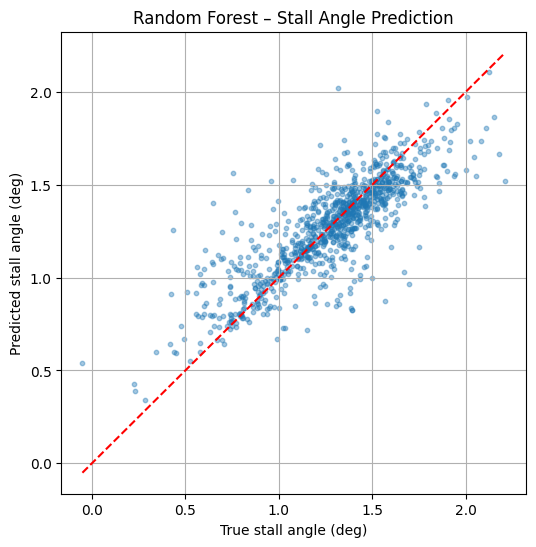

In [23]:
#Plot the predicted vs true stall angle based calculation data?
plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_pred, s=10, alpha=0.4)
min_v = min(y_val.min(), y_pred.min())
max_v = max(y_val.max(), y_pred.max())
plt.plot([min_v, max_v], [min_v, max_v], "r--")
plt.xlabel("True stall angle (deg)")
plt.ylabel("Predicted stall angle (deg)")
plt.title("Random Forest – Stall Angle Prediction")
plt.grid(True)
plt.show()
